# Construindo chatbot de atendimento médico com técnicas tradicionais de machine learning

## Imports

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from collections import defaultdict

## Dataset

### Construindo o dataset para o chatboot médico

In [29]:
# Dados base com perguntas, categorias e respostas
data = [
    ("Quais são os sintomas da gripe?", "gripe", "Os sintomas da gripe incluem febre, dor no corpo, calafrios, dor de garganta e tosse."),
    ("Estou com febre e dor no corpo, é gripe?", "gripe", "Esses sintomas são comuns na gripe. Se você estiver com tosse e dor no corpo também, pode ser a gripe."),
    ("Como saber se estou gripado?", "gripe", "A gripe geralmente apresenta febre, calafrios, dor de cabeça e dor muscular. Se você tiver esses sintomas, é possível que seja gripe."),
    ("Estou com febre alta e dor no corpo, o que pode ser?", "gripe", "Esses sintomas podem ser causados por várias condições, como a gripe ou até a Covid-19. Você já teve contato com alguém que testou positivo para Covid-19 recentemente?"),
    ("Não, mas estou com tosse também.", "gripe", "A tosse junto com febre é uma característica comum da gripe. Recomendo que você procure um médico para uma avaliação mais detalhada."),
    
    ("Quais os sintomas de um infarto?", "cardiologia", "Os sintomas incluem dor no peito, falta de ar, dor nas costas e suor excessivo."),
    ("Estou com dor no peito e falta de ar, isso pode ser um infarto?", "cardiologia", "Sim, esses podem ser sintomas de infarto. Procure ajuda médica imediatamente."),
    ("Quais exames devo fazer para checar a saúde do coração?", "cardiologia", "Os exames mais comuns incluem o eletrocardiograma (ECG), ecocardiograma e testes de esforço."),
    ("Como posso saber se meu colesterol está alto?", "cardiologia", "Você pode verificar seu colesterol através de um exame de sangue chamado lipidograma, que mede os níveis de colesterol e triglicerídeos."),

    ("Como posso tratar acne?", "dermatologia", "A acne pode ser tratada com medicamentos tópicos, como peróxido de benzoíla ou cremes com retinoides."),
    ("Tenho espinhas no rosto, o que devo fazer?", "dermatologia", "Você pode usar cremes específicos para acne e evitar apertar as espinhas. Se necessário, consulte um dermatologista."),

    ("O que é depressão?", "saude_mental", "A depressão é um transtorno mental caracterizado por sentimentos persistentes de tristeza, perda de interesse nas atividades diárias e cansaço extremo."),
    ("Quais são os sintomas da depressão?", "saude_mental", "Os sintomas incluem tristeza constante, dificuldade de concentração, insônia ou sono excessivo, e perda de apetite."),

    ("Qual a melhor dieta para perder peso?", "nutricao", "Uma dieta balanceada, com controle de calorias e aumento do consumo de vegetais, é eficaz para perda de peso."),
    ("Devo cortar carboidratos para emagrecer?", "nutricao", "Não é necessário cortar carboidratos totalmente. O importante é escolher carboidratos saudáveis e consumi-los com moderação."),

    ("Vocês aceitam plano de saúde X?", "convenios", "Sim, aceitamos o plano de saúde X. Você pode consultar as coberturas diretamente com nossa recepção."),
    ("Quais planos de saúde vocês aceitam?", "convenios", "Aceitamos planos como Amil, Bradesco Saúde e Unimed. Consulte as condições com a recepção."),

    ("Como posso agendar uma consulta?", "consultas", "Você pode agendar sua consulta através do nosso portal online ou entrando em contato com a recepção."),
    ("Preciso levar algum exame para a consulta?", "consultas", "Recomendamos que leve os exames mais recentes, caso tenha algum, para facilitar a avaliação do médico."),

    ("Qual o melhor tratamento para dor nas costas?", "ortopedia", "O tratamento pode incluir fisioterapia, medicamentos anti-inflamatórios e, em alguns casos, cirurgia."),
    ("Estou com dor nas costas, o que pode ser?", "ortopedia", "A dor nas costas pode ser causada por tensão muscular, problemas na coluna ou até uma hérnia. É importante procurar um médico para diagnóstico."),
    ("Como saber se a dor nas costas é grave?", "ortopedia", "A dor nas costas pode ser grave se for acompanhada de dormência, fraqueza nas pernas ou dificuldade de movimentação. Caso esses sintomas apareçam, procure um médico imediatamente."),

    ("Estou com muita dor de cabeça, o que posso fazer?", "neurologia", "Se a dor de cabeça for muito forte e persistir, pode ser sinal de enxaqueca ou outro problema. Tente descansar em um local tranquilo e tomar um analgésico, mas se persistir, consulte um médico.")
]


category_dict = defaultdict(list)
for q, c, a in data:
    category_dict[c].append((q, a))

# Gerar dados sintéticos balanceados
synthetic_data = []
target_per_class = 500

for category, qa_list in category_dict.items():
    for _ in range(target_per_class):
        q, a = random.choice(qa_list)
        # Introduzir leve embaralhamento nas perguntas
        q_words = q.split()
        random.shuffle(q_words)
        shuffled_q = ' '.join(q_words)
        synthetic_data.append((shuffled_q, category, a))

# Embaralhar os dados
random.shuffle(synthetic_data)

# Converter para DataFrame
df = pd.DataFrame(synthetic_data, columns=["pergunta", "categoria", "resposta"])
df.to_csv('../data/processed/nlp_chatbot_dataset.csv')

### Lendo o dataset criado

In [30]:
df = pd.read_csv('../data/processed/nlp_chatbot_dataset.csv').drop('Unnamed: 0', axis=1)
df.head()

,pergunta,categoria,resposta
0,"o que muita dor cabeça, fazer? com Estou posso de",neurologia,Se a dor de cabeça for muito forte e persistir...
1,saúde de aceitam X? Vocês plano,convenios,"Sim, aceitamos o plano de saúde X. Você pode c..."
2,"fazer? rosto, devo que no espinhas Tenho o",dermatologia,Você pode usar cremes específicos para acne e ...
3,da sintomas Quais os são depressão?,saude_mental,"Os sintomas incluem tristeza constante, dificu..."
4,se meu Como saber está posso colesterol alto?,cardiologia,Você pode verificar seu colesterol através de ...


## Explorando o dataset

### Colunas

In [11]:
df.columns

Index(['pergunta', 'categoria', 'resposta'], dtype='object')

### Dimensões

In [12]:
df.shape

(4500, 3)

### Verificando existência de valores nulos

In [13]:
df.isna().sum()

pergunta     0
categoria    0
resposta     0
dtype: int64

### Quantidade de caracteres para cada variável (pergunta, categoria e reposta)

In [14]:
df['caracteres_pergunta'] = df.pergunta.apply(lambda x: len(x))
df['caracteres_categoria'] = df.categoria.apply(lambda x: len(x))
df['caracteres_resposta'] = df.resposta.apply(lambda x: len(x))

df.head()

,pergunta,categoria,resposta,caracteres_pergunta,caracteres_categoria,caracteres_resposta
0,"Tenho devo o rosto, que no fazer? espinhas",dermatologia,Você pode usar cremes específicos para acne e ...,42,12,116
1,"com dor o Estou nas pode ser? costas, que",ortopedia,A dor nas costas pode ser causada por tensão m...,41,9,143
2,aceitam X? plano de Vocês saúde,convenios,"Sim, aceitamos o plano de saúde X. Você pode c...",31,9,100
3,"posso Estou com de o dor cabeça, que fazer? muita",neurologia,Se a dor de cabeça for muito forte e persistir...,49,10,193
4,"o Estou nas costas, que pode ser? com dor",ortopedia,A dor nas costas pode ser causada por tensão m...,41,9,143


### Distribuição das categorias

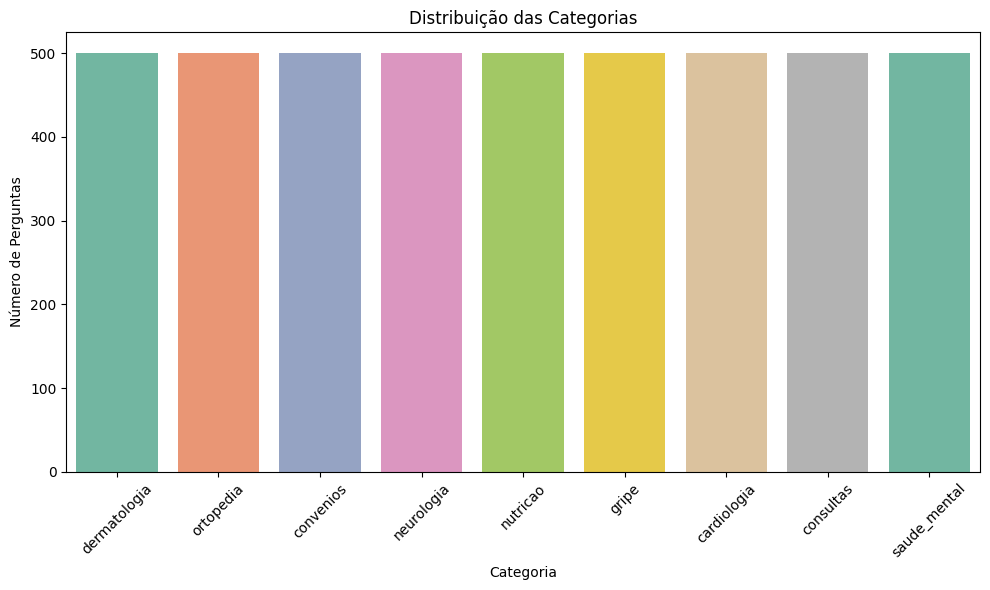

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(
    data=df,
    x='categoria',
    hue='categoria',
    order=df['categoria'].value_counts().index,
    palette='Set2',
    legend=False
)
plt.title('Distribuição das Categorias')
plt.xlabel('Categoria')
plt.ylabel('Número de Perguntas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
df.categoria.value_counts()

categoria
dermatologia    500
ortopedia       500
convenios       500
neurologia      500
nutricao        500
gripe           500
cardiologia     500
consultas       500
saude_mental    500
Name: count, dtype: int64

## Pré-processamento dos dados

### Função de pré-processamento de texto

In [34]:
# Função de pré-processamento do texto
def preprocess_text(text):
    # Transformando para minúsculas
    text = text.lower()
    
    # Remover símbolos e pontuação usando expressão regular
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Função para avaliar métricas do modelo
def evaluate_model(modelo, X_test, y_test, y_pred=None, titulo=''):
    # Prever se não foi passado y_pred
    if y_pred is None:
        y_pred = modelo.predict(X_test)
    
    # Acurácia
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc:.4f}")
    
    # Relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=modelo.classes_, yticklabels=modelo.classes_)
    plt.title(f'Matriz de Confusão - {titulo}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    # Curva ROC e AUC
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_test)
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_test)
    else:
        print("Modelo não suporta ROC/AUC (sem predict_proba ou decision_function).")
        return
    
    n_classes = y_test_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC - {titulo}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


### Relizando limpeza de elementos não significativos nas perguntas

In [18]:
# Aplicando o pré-processamento nas perguntas
df['pergunta'] = df['pergunta'].apply(preprocess_text)
df.head()

,pergunta,categoria,resposta,caracteres_pergunta,caracteres_categoria,caracteres_resposta
0,tenho devo o rosto que no fazer espinhas,dermatologia,Você pode usar cremes específicos para acne e ...,42,12,116
1,com dor o estou nas pode ser costas que,ortopedia,A dor nas costas pode ser causada por tensão m...,41,9,143
2,aceitam x plano de vocês saúde,convenios,"Sim, aceitamos o plano de saúde X. Você pode c...",31,9,100
3,posso estou com de o dor cabeça que fazer muita,neurologia,Se a dor de cabeça for muito forte e persistir...,49,10,193
4,o estou nas costas que pode ser com dor,ortopedia,A dor nas costas pode ser causada por tensão m...,41,9,143


### Vetorizando os dados usando TF-IDF

In [19]:
# Vetorizador TF-IDF
vectorizer = TfidfVectorizer()

# Transformando as perguntas em vetores TF-IDF
X = vectorizer.fit_transform(df['pergunta'])

# As categorias serão os rótulos (y)
y = df['categoria']

### Imprimindo a matriz esparsa da vetorização

In [20]:
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
X_df.head()

,aceitam,acne,agendar,algum,alta,alto,ar,cabeça,carboidratos,checar,...,sintomas,são,também,tenho,tosse,tratamento,tratar,um,uma,vocês
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.448464,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.454897,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.454897
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.413959,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


### Convertendo as labels literais em labels numéricas

In [21]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Se quiser ver o resultado:
print("Categorias codificadas:", y_encoded)
print("Classes:", encoder.classes_)

Categorias codificadas: [3 7 2 ... 6 7 5]
Classes: ['cardiologia' 'consultas' 'convenios' 'dermatologia' 'gripe' 'neurologia'
 'nutricao' 'ortopedia' 'saude_mental']


## Treinamento dos modelos

### Separando conjunto de dados em treino e teste

In [22]:
# Separar os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

### Regressão Logística

Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       164
           4       1.00      1.00      1.00       167
           5       1.00      1.00      1.00       163
           6       1.00      1.00      1.00       146
           7       1.00      1.00      1.00       131
           8       1.00      1.00      1.00       150

    accuracy                           1.00      1350
   macro avg       1.00      1.00      1.00      1350
weighted avg       1.00      1.00      1.00      1350



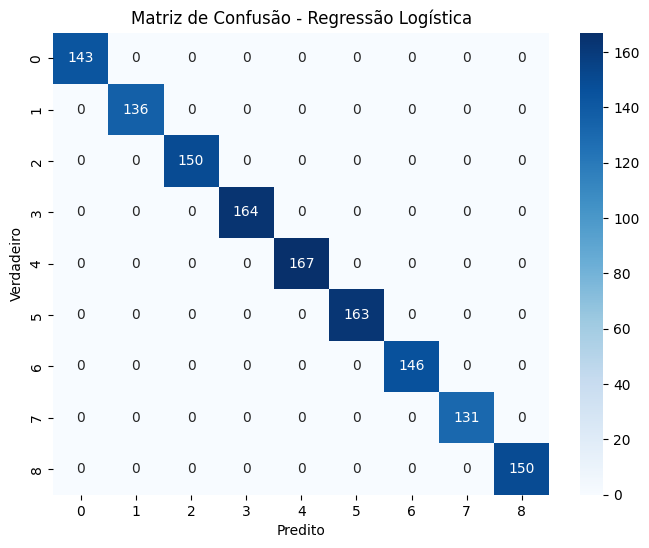

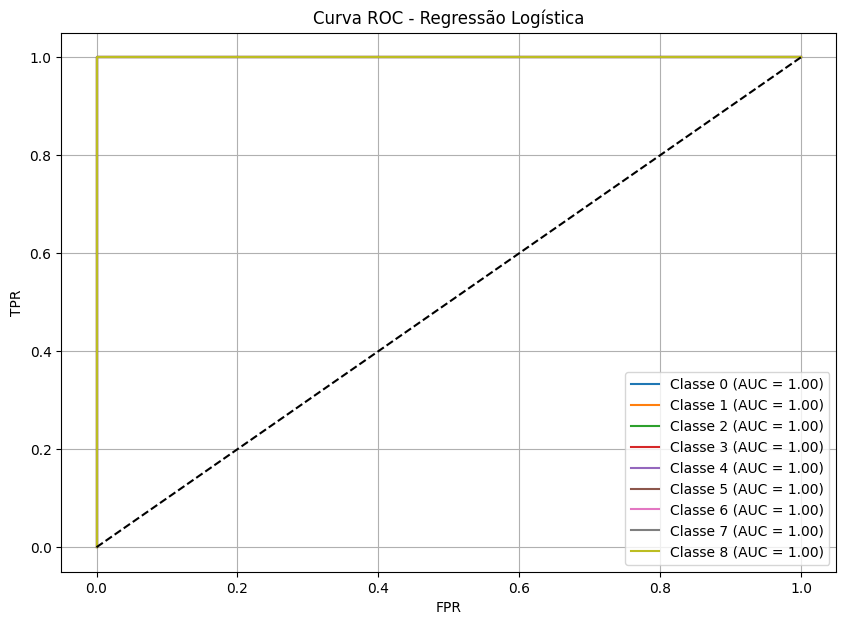

In [37]:
# Instanciar e treinar o modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Avaliando desempenho do modelo
evaluate_model(model, X_test, y_test, titulo='Regressão Logística')

### Random Forest

Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       164
           4       1.00      1.00      1.00       167
           5       1.00      1.00      1.00       163
           6       1.00      1.00      1.00       146
           7       1.00      1.00      1.00       131
           8       1.00      1.00      1.00       150

    accuracy                           1.00      1350
   macro avg       1.00      1.00      1.00      1350
weighted avg       1.00      1.00      1.00      1350



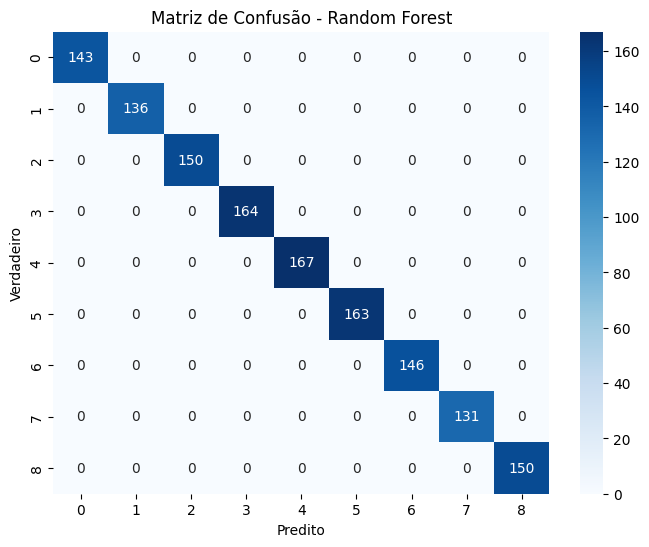

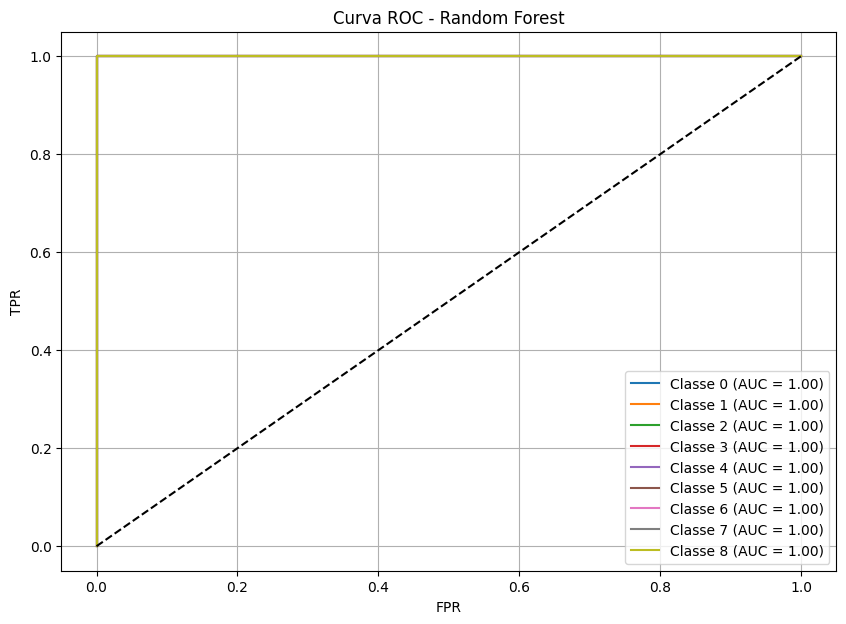

In [39]:
# Treinamento do modelo
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Avaliando desempenho do modelo
evaluate_model(rf_model, X_test, y_test, titulo='Random Forest')

### K-Nearest Neighbors

Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       164
           4       1.00      1.00      1.00       167
           5       1.00      1.00      1.00       163
           6       1.00      1.00      1.00       146
           7       1.00      1.00      1.00       131
           8       1.00      1.00      1.00       150

    accuracy                           1.00      1350
   macro avg       1.00      1.00      1.00      1350
weighted avg       1.00      1.00      1.00      1350



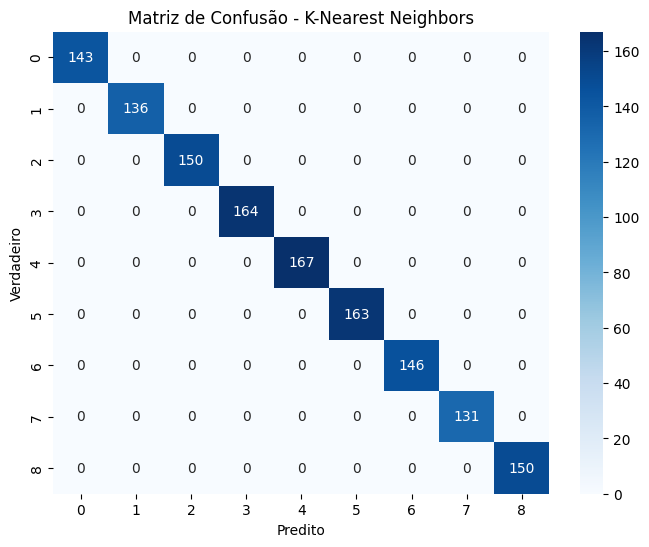

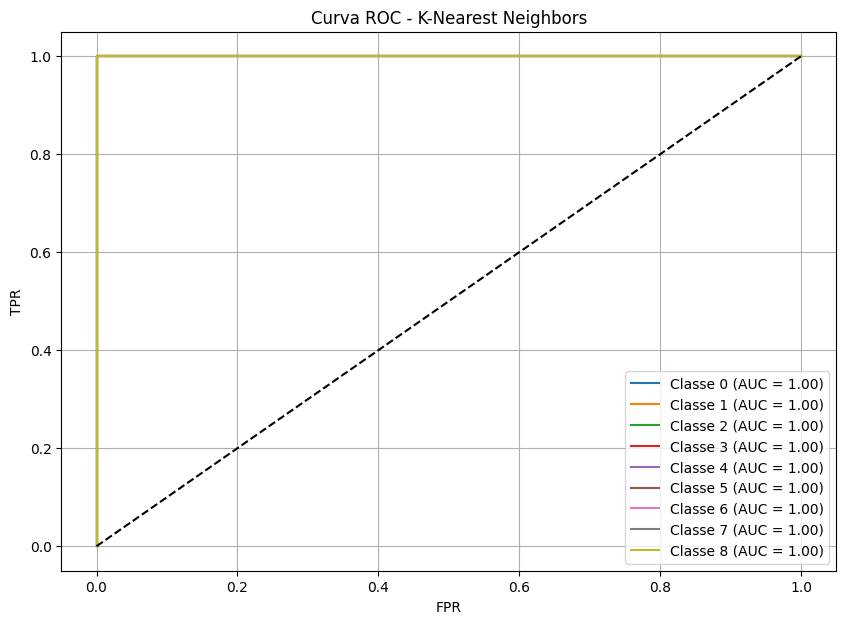

In [40]:
# Criar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)

# Treinar o modelo
knn.fit(X_train, y_train)

# Avaliando desempenho do modelo
evaluate_model(knn, X_test, y_test, titulo='K-Nearest Neighbors')

### Support Vector Machines

Acurácia: 1.0000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       164
           4       1.00      1.00      1.00       167
           5       1.00      1.00      1.00       163
           6       1.00      1.00      1.00       146
           7       1.00      1.00      1.00       131
           8       1.00      1.00      1.00       150

    accuracy                           1.00      1350
   macro avg       1.00      1.00      1.00      1350
weighted avg       1.00      1.00      1.00      1350



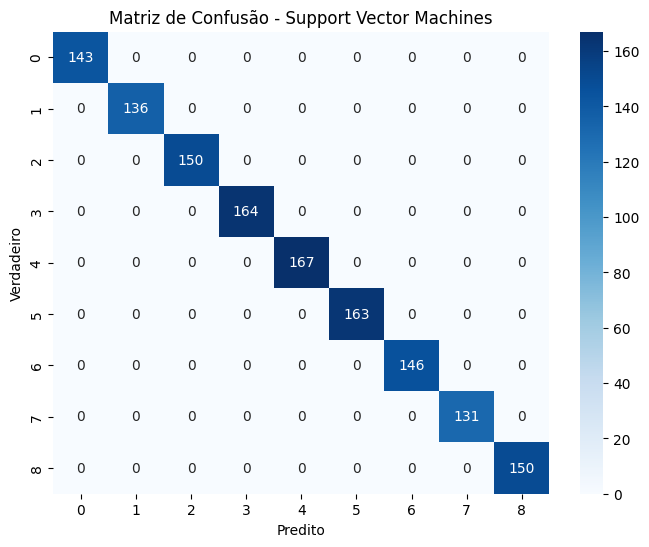

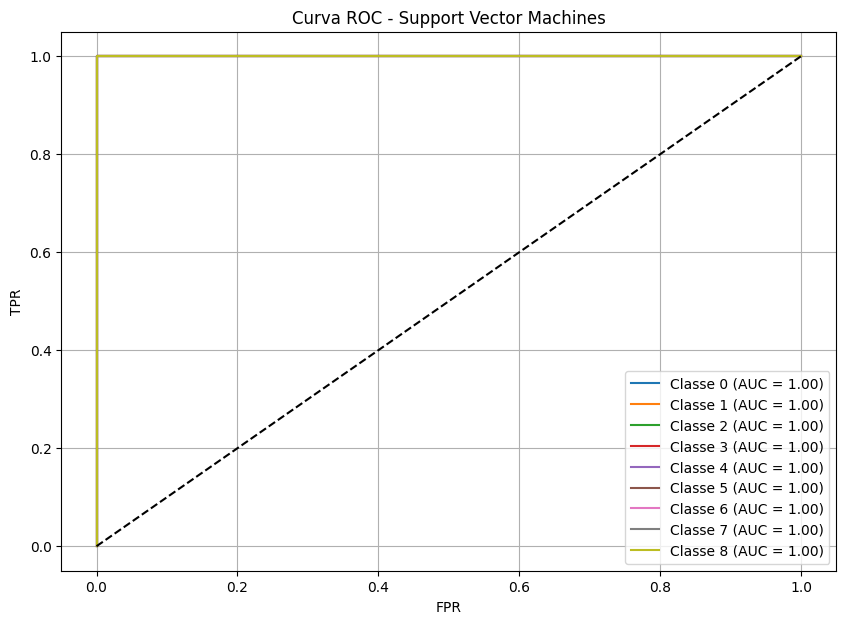

In [41]:
# Inicializando o modelo SVM
svm_model = SVC(kernel='linear')  # Usando um kernel linear

# Treinando o modelo com os dados
svm_model.fit(X_train, y_train)

# Avaliando desempenho do modelo
evaluate_model(svm_model, X_test, y_test, titulo='Support Vector Machines')